# 正規分布
## 目的
***
- データが正規分布から生成されていると仮定してベイズ推定よりパラメータの事後分布を得る
- パラメータの事後分布サンプルから予測分布を生成する

## 参考文献
***
- [Pythonによるベイズ統計モデリング-PyMCでのデータ分析実践ガイド-](https://www.kyoritsu-pub.co.jp/bookdetail/9784320113374)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import warnings
warnings.filterwarnings('ignore')

## データセット

In [2]:
df = pd.DataFrame({
    'data': [51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 
             51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 
             57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 
             51.94, 54.95, 50.39, 52.91, 51.50, 52.68, 47.72, 49.73, 51.82, 
             54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 
             54.30, 53.84, 53.16]
})

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
data,48.0,53.496458,3.456198,47.72,51.5825,52.875,54.96,68.58


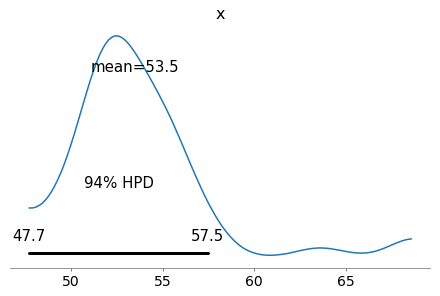

In [4]:
az.plot_posterior(df.values)
plt.show()

## ベイズ推定
***
- mc_error: 数値解による誤差
- hpd2.5~hpd97.5: 95%信用区間
- n_eff: 有効サンプル数（サンプリング数の10%以下の場合は自己相関が強い）
- Rhat: MCMCの収束度（1に近いほどMCMCが収束している）

In [5]:
with pm.Model() as model:
    mu     = pm.Uniform('mu', df['data'].min(), df['data'].max())
    sigma  = pm.HalfNormal('sigma', sd=1e4)
    y_pred = pm.Normal('y_pred', mu=mu, sd=sigma, observed=df.values)
    
    trace  = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:07<00:00, 1385.99draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.497523,0.511614,0.006102,52.467825,54.480284,7788.211797,0.999985
sigma,3.554393,0.377340,0.004134,2.867520,4.295974,7118.682704,0.999942


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e6829e8>,
      dtype=object)

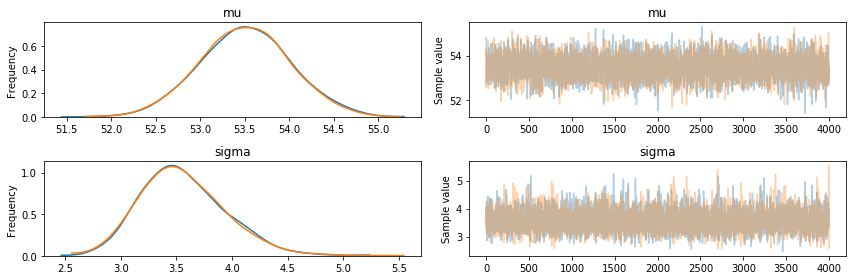

In [6]:
chain = trace[1000:]
display(pm.summary(chain))
display(pm.traceplot(chain))

100%|██████████| 100/100 [00:00<00:00, 102.28it/s]


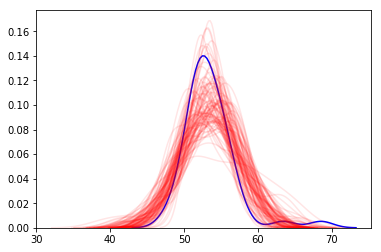

In [7]:
y = pm.sample_ppc(chain, 100, model, size=len(df))
sns.kdeplot(df['data'].values, c='b')
for i in y['y_pred']:
    sns.kdeplot(i[0].T[0], c='r', alpha=0.1)